UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc.

The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age
[gender] is either 0 (male) or 1 (female)
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras

Using TensorFlow backend.


In [2]:
#%%bash
#ls ./input/utkface_aligned_cropped
# it seems crop_part1 conists of subset of data contained in UTKFace so we won't be using it.

**Constants**

In [3]:
DATA_DIR = "./UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_RACE_MAP, RACE_ID_MAP

({0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [4]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None

In [5]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

In [6]:
attributes = list(map(parse_filepath, files))

./UTKFace/61_1_20170109150557335.jpg.chip.jpg
./UTKFace/39_1_20170116174525125.jpg.chip.jpg
./UTKFace/61_1_20170109142408075.jpg.chip.jpg


In [7]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'race', 'file']
df = df.dropna()
df.head()

,age,race,file
0,18.0,white,./UTKFace/18_0_0_20170117135529944.jpg.chip.jpg
1,26.0,white,./UTKFace/26_0_0_20170114032951327.jpg.chip.jpg
2,23.0,asian,./UTKFace/23_0_2_20170116172927637.jpg.chip.jpg
3,27.0,black,./UTKFace/27_1_1_20170113012427688.jpg.chip.jpg
4,26.0,white,./UTKFace/26_0_0_20170117195448787.jpg.chip.jpg


# Exploratory analysis

In [8]:
df.describe()

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


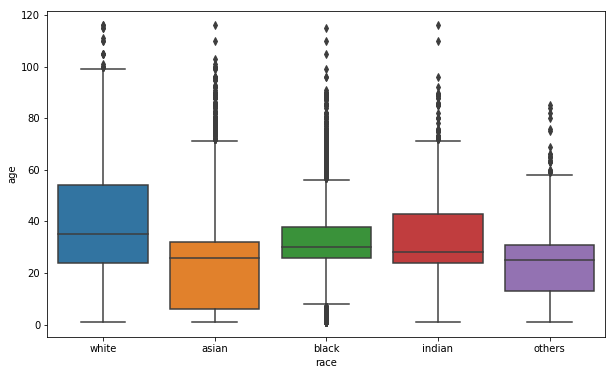

In [9]:
fig, (ax2) = plt.subplots(1, figsize=(10, 6))
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

From the plot we can see that most of people are within 10 and 55 years of age. Most probably, we'll discard the dataset for rest of the ages.

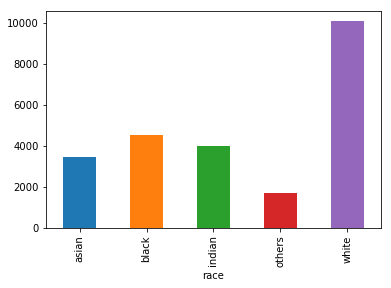

In [10]:
df.groupby(by=['race'])['age'].count().plot(kind='bar')

It turns out that there are many images of *white male* and *while female*. images from *others* category are very less in number compared to rest of the categories especially *white* category.
Let's analyze our data from *age* perspective.

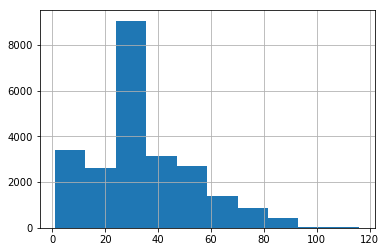

In [11]:
df['age'].hist()

In [12]:
df['age'].describe()

count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [13]:
df = df[(df['age'] > 10) & (df['age'] < 65)]

# Data prep

In [14]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(9079, 3891, 5559, 64.0)

In [16]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race = r['file'], r['age'], r['race_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races)]
                images, races = [], []
        if not for_training:
            break

# Model training

In [4]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for race prediction
_ = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)

model = Model(inputs=input_layer, outputs=[race_output])
model.compile(optimizer='rmsprop', 
              loss={'race_output': 'categorical_crossentropy'},
              loss_weights={'race_output': 1.5},
              metrics={'race_output': 'accuracy'})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 198, 198, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 194, 194, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 194, 194, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 97, 97, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 95, 95, 96)        55392     
_________________________________________________________________
batch_normalization_2 (Batch (None, 95, 95, 96)        384       
__________

In [19]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)
                    


Epoch 1/10


ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([], shape=(0, 1), dtype=float64), array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...

In [52]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(history.history['race_output_acc'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_acc'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

NameError: name 'history' is not defined

In [56]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

NameError: name 'get_data_generator' is not defined

In [55]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (race_true)= next(test_gen)
race_pred = model.predict_on_batch(x_test)

NameError: name 'get_data_generator' is not defined

In [54]:
race_true = race_true.argmax(axis=-1)
race_pred = race_pred.argmax(axis=-1)

NameError: name 'race_true' is not defined

In [ ]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

In [ ]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('r:{}'.format(ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('r:{}'.format(ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])
    